# Pachon DIMM data note 1 figures

## jupyter boilerplate

Imports of python modules I usually want when working a a jupyter notebook.

In [1]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
import sys
import os
from collections import namedtuple
from functools import partial
from datetime import datetime, timedelta

import astropy
import astropy.coordinates
import astropy.units as u
from astropy.coordinates import EarthLocation, get_sun, AltAz
import psycopg2
import numpy as np
import pandas as pd
import scipy
import scipy.stats
import healpy
import matplotlib as mpl
import matplotlib.pyplot as plt
import ipywidgets as widgets
from mpl_toolkits.basemap import Basemap
# importing easyaccess resets some pandas parameters to unfortunate values
pd.options.display.max_rows = 10

import statsmodels.graphics.tsaplots
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import AR
from scipy.stats import anderson_ksamp
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.optimize import curve_fit
from statsmodels.formula.api import ols as formula_ols

mpl.rcParams['figure.figsize'] = (8, 5)
plt.style.use('ggplot')
np.random.seed(6563)


/data/des60.b/data/neilsen/anaconda/envs/ehn35/lib/python3.5/site-packages/matplotlib/__init__.py:898: MatplotlibDeprecationWarning: The backend.qt4 rcParam was deprecated in version 2.2.  In order to force the use of a specific Qt binding, either import that binding first, or set the QT_API environment variable.
  mplDeprecation)
/data/des60.b/data/neilsen/anaconda/envs/ehn35/lib/python3.5/site-packages/matplotlib/__init__.py:898: MatplotlibDeprecationWarning: The backend.qt4 rcParam was deprecated in version 2.2.  In order to force the use of a specific Qt binding, either import that binding first, or set the QT_API environment variable.
  mplDeprecation)


/data/des60.b/data/neilsen/anaconda/envs/ehn35/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Load the Pachon DIMM data

The data from the DIMM Pachon loaded here was provided to me by Edison Bustos in email on 2018-03-21. It contains time stamps and seeing estimates from Pachon DIMM data. These estimates arise from an equation that assumes Kolmogorov seeing, and are calculated for a wavelongth of 500nm. See equation 5 of Tokovinin 2002 (2002PASP..114.1156T).

### Read the raw data

The email included two separate files with diffirent date ranges. Read both and merge them.

In [2]:
dimm_old = pd.read_table('/data/des70.a/data/neilsen/obs_strat/data/pachon.Pachon_seeing-2004-2016.txt.bz2', sep="\t", parse_dates=[0])
dimm_old.drop('meandx', axis=1, inplace=True)
dimm_old.columns = ['time', 'seeing']
dimm_new = pd.read_table('/data/des70.a/data/neilsen/obs_strat/data/PachonSM.DIMM-2016-2018.txt.bz2', sep="\t", parse_dates=[0])
dimm = pd.concat([dimm_old, dimm_new])
dimm.sort_values('time', ascending=True, inplace=True)
dimm.set_index('time', inplace=True)
dimm = dimm.groupby(level=0).mean()
dimm.head()

,seeing
time,
2004-03-17 02:33:15,0.71
2004-03-17 02:34:35,0.74
2004-03-17 02:35:42,0.74
2004-03-17 02:36:49,0.75
2004-03-17 02:37:58,0.72


### Filter out unreasonable values

In [3]:
dimm.query('(seeing < 5) & (seeing > 0.1)', inplace=True)

### Calculate $r_{0}$

Rather than use the seeing estimate from the Kolmogorov-derived equation, use the Fried paramater.

In [4]:
dimm['r0'] = 0.98*5e-7/np.radians(dimm.seeing/(60*60))
dimm['log_r0'] = np.log10(dimm.r0)

### Calculate von Karman seeing

Tokovinin 2002 provides an equation (eqn 19) that approximates the seeing for a given Fried paramater assuming a von Karman model. This model requires an estime of the outer scale of the seeing, $L_0$. A value for $L_0$ is poorly known; the only estimate I can find is from Ziad et al 2000 (2000ApOpt..39.5415Z), which gives a value of 28.4 -13.3/+25.0 meters. I will use a value of 30 meters.

In [5]:
def calc_FWHM_vK(fwhm_dimm, outer_scale=30, wavelength=5.0e-7):
    r0 = 0.98*wavelength/(np.radians(fwhm_dimm/(60*60)))
    fwhm = fwhm_dimm * np.sqrt(1.0 - 2.813*np.power(r0/outer_scale, 0.356) )
    return fwhm

dimm['vk_seeing'] = calc_FWHM_vK(dimm.seeing, 30)

In [6]:
dimm.describe()

,seeing,r0,log_r0,vk_seeing
count,1.160434e+06,1.160434e+06,1.160434e+06,1.160434e+06
mean,8.834132e-01,1.286241e-01,-9.148330e-01,6.940753e-01
std,3.431807e-01,4.293256e-02,1.480070e-01,3.023545e-01
min,1.010000e-01,2.038930e-02,-1.690598e+00,4.060876e-02
25%,6.600000e-01,9.918524e-02,-1.003553e+00,4.984043e-01
50%,8.100000e-01,1.247775e-01,-9.038638e-01,6.276740e-01
75%,1.019000e+00,1.531360e-01,-8.149227e-01,8.099793e-01
max,4.957000e+00,1.000691e+00,2.998394e-04,4.406898e+00


### Plot the time series

First, set some date columns to make plotting more convenient.

In [7]:
dimm['month'] = dimm.index.month
dimm['year'] = dimm.index.year
dimm['data_month'] = 12*(dimm.year - np.min(dimm.year)) + dimm.month
dimm['mjd'] = dimm.index.to_julian_date() - 2400000.5

# Pachon is at a longitude of 70.8062
# night is like mjd, but shifts the rollover to be local solar noon
ctio_night_shift = (180.0-70.8062)/360.0
dimm['night'] = np.floor(dimm.mjd + ctio_night_shift).astype(int)

I'll start by just plotting the time series, averaged by month. 

I plot include a [lowess](https://en.wikipedia.org/wiki/Local_regression) smoothed curved through the points, which just estimates a smooth function by doing linear fits to nearby points.

/data/des60.b/data/neilsen/anaconda/envs/ehn35/lib/python3.5/site-packages/matplotlib/legend.py:593: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fa87ac9aeb8> has a label of '_no_label_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))
/data/des60.b/data/neilsen/anaconda/envs/ehn35/lib/python3.5/site-packages/matplotlib/legend.py:593: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fa87aca3e48> has a label of '_no_label_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


Text(0,0.5,'FWHM (asec)')

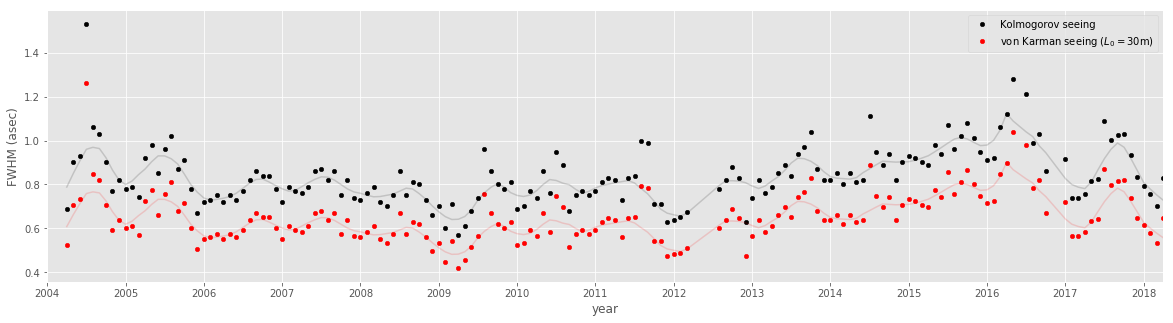

In [8]:
mpl.rcParams['figure.figsize'] = (20, 5)
fig, axes = plt.subplots()

df = dimm.groupby('data_month').agg({'seeing': 'median', 'vk_seeing': 'median'}).reset_index()
df.plot.scatter('data_month', 'seeing', color='black', label='Kolmogorov seeing', ax=axes)
df.plot.scatter('data_month', 'vk_seeing', color='red', label='von Karman seeing ($L_0=30$m)', ax=axes)

df['seeing_lowess'] = lowess(df.seeing, df.data_month, frac=0.05).T[1]
df.plot('data_month', 'seeing_lowess', color='black', alpha=0.15, label='_no_label_', ax=axes)
df['vk_seeing_lowess'] = lowess(df.vk_seeing, df.data_month, frac=0.05).T[1]
df.plot('data_month', 'vk_seeing_lowess', color='red', alpha=0.15, label='_no_label_', ax=axes)

month_ticks = np.arange(0, 180, 12)
axes.set_xticks(month_ticks)
axes.set_xticklabels(np.min(dimm.year) + (month_ticks/12).astype(int))
axes.set_xlabel('year')
axes.set_ylabel('FWHM (asec)')

Text(0,0.5,'FWHM (asec)')

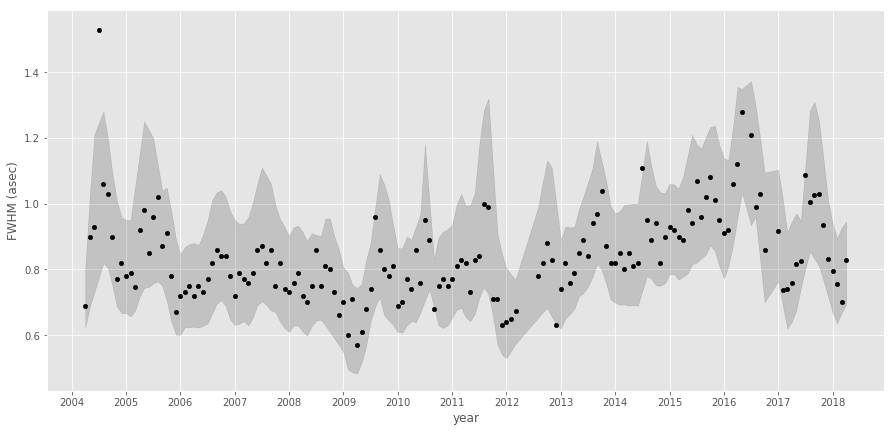

In [9]:
mpl.rcParams['figure.figsize'] = (15, 7)
fig, axes = plt.subplots()

df = dimm.groupby('data_month')[['seeing', 'vk_seeing']].describe().reset_index()
df.plot.scatter('data_month', ('seeing', '50%'), color='black', label='Kolmogorov seeing', ax=axes, legend=False)

frac = 6.0/(12*(2018-2004))
df[('seeing', 'lowess_25')] = lowess(df[('seeing', '25%')], df.data_month, frac=frac).T[1]
df[('seeing', 'lowess_75')] = lowess(df[('seeing', '75%')], df.data_month, frac=frac).T[1]
#df.plot('data_month', ('seeing', 'lowess_25'), color='black', alpha=0.15, label='_no_label_', ax=axes)
#df.plot('data_month', ('seeing', 'lowess_75'), color='black', alpha=0.15, label='_no_label_', ax=axes)

axes.fill_between(df['data_month'], df[('seeing', 'lowess_25')], df[('seeing', 'lowess_75')], color='black', alpha=0.15, label='_no_label_')

month_ticks = np.arange(0, 180, 12)
axes.set_xticks(month_ticks)
axes.set_xticklabels(np.min(dimm.year) + (month_ticks/12).astype(int))
axes.set_xlabel('year')
axes.set_ylabel('FWHM (asec)')

Text(0.5,0,'lag (years)')

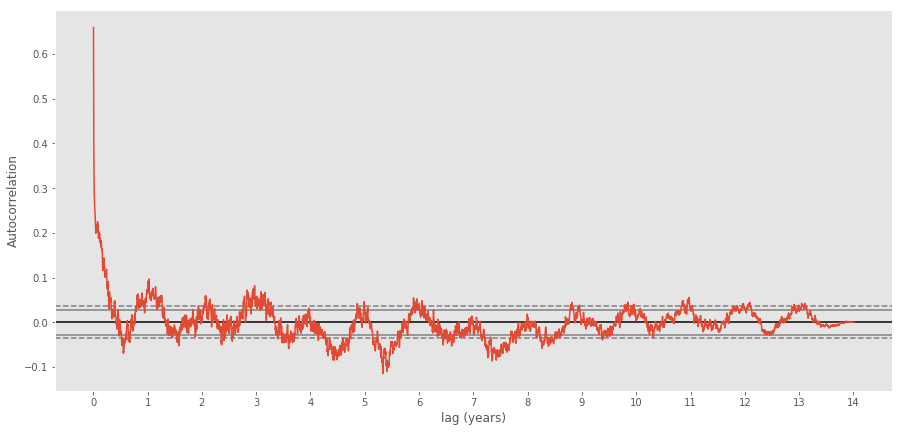

In [71]:
#mpl.rcParams['figure.figsize'] = (8, 5)
mpl.rcParams['figure.figsize'] = (15, 7)
fig, axes = plt.subplots()
df = pd.DataFrame({'night': np.arange(dimm.night.min(), dimm.night.max()), 'dummy': 0}).set_index('night')
df['log_r0'] = dimm.groupby('night')['log_r0'].mean().copy()
df.log_r0.fillna(method='ffill', inplace=True)
pd.plotting.autocorrelation_plot(df.log_r0, ax=axes)
axes.set_xticks(np.arange(0, dimm.night.max()-dimm.night.min(),365))
axes.set_xticklabels(np.arange(0, 15))
axes.set_xlabel('lag (years)')

Text(0.5,0,'lag (years)')

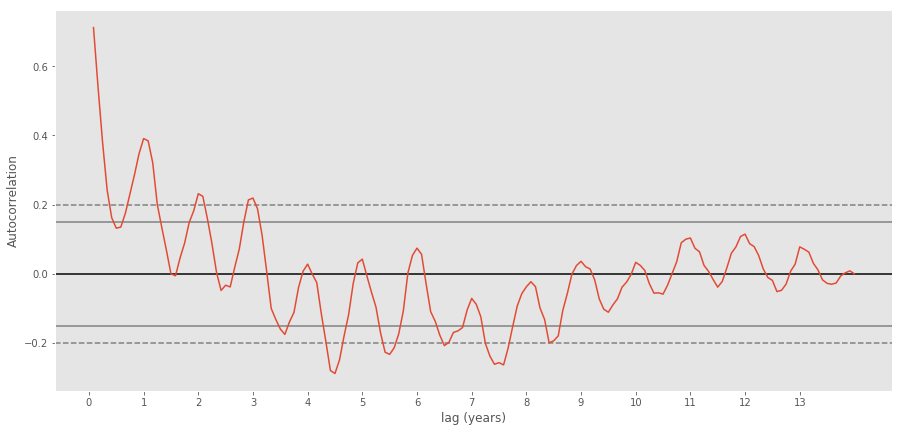

In [74]:
#mpl.rcParams['figure.figsize'] = (8, 5)
mpl.rcParams['figure.figsize'] = (15, 7)
fig, axes = plt.subplots()
df = pd.DataFrame({'data_month': np.arange(dimm.data_month.min(), dimm.data_month.max()), 'dummy': 0}).set_index('data_month')
df['log_r0'] = dimm.groupby('data_month')['log_r0'].mean().copy()
df.log_r0.fillna(method='ffill', inplace=True)
pd.plotting.autocorrelation_plot(df.log_r0, ax=axes)
axes.set_xticks(np.arange(0, dimm.data_month.max()-dimm.data_month.min(),12))
axes.set_xticklabels(np.arange(0, 15*12))
axes.set_xlabel('lag (years)')

In [66]:
df.head()

,night,log_r0
0,53081,-0.857619
1,53087,-0.830704
2,53088,-0.879178
3,53089,-0.818343
4,53090,-0.838175


In [10]:
dimm.groupby('data_month')[['seeing', 'vk_seeing']].describe().reset_index()

data_month   seeing                                                   \
                  count      mean       std    min    25%    50%     75%   
0            3   2137.0  0.717197  0.163331  0.420  0.610  0.690  0.7800   
1            4   7188.0  0.929688  0.274845  0.370  0.720  0.900  1.1000   
2            5   9834.0  1.027387  0.397657  0.300  0.730  0.930  1.2100   
3            6   4534.0  1.513485  0.579219  0.350  1.040  1.530  1.9600   
4            7   7688.0  1.065585  0.347437  0.320  0.820  1.060  1.2800   
..         ...      ...       ...       ...    ...    ...    ...     ...   
157        167  10147.0  0.862433  0.252448  0.349  0.687  0.833  0.9775   
158        168  13326.0  0.847086  0.249052  0.342  0.680  0.795  0.9430   
159        169  11507.0  0.781284  0.210946  0.281  0.634  0.755  0.9020   
160        170  11657.0  0.726354  0.203915  0.257  0.597  0.702  0.8160   
161        171  11211.0  0.854855  0.201576  0.441  0.714  0.830  0.9660   

           vk_seeing                                                    \
       max     count      mean       std       min       25%       50%   
0    1.980    2137.0  0.548339  0.141807  0.295568  0.455683  0.524132   
1    3.200    7188.0  0.733606  0.240722  0.254183  0.549927  0.705905   
2    3.340    9834.0  0.820367  0.351724  0.196954  0.558539  0.732078   
3    3.540    4534.0  1.252846  0.516378  0.237741  0.828413  1.262993   
4    2.870    7688.0  0.853429  0.305514  0.213211  0.636344  0.845986   
..     ...       ...       ...       ...       ...       ...       ...   
157  3.090   10147.0  0.674793  0.220917  0.236921  0.521557  0.647623   
158  3.187   13326.0  0.661377  0.218297  0.231183  0.515549  0.614681   
159  2.748   11507.0  0.604146  0.183083  0.181588  0.476163  0.580100   
160  2.529   11657.0  0.556683  0.177072  0.162296  0.444610  0.534442   
161  2.137   11211.0  0.667679  0.175836  0.313058  0.544763  0.645019   

                         
          75%       max  
0    0.601701  1.667632  
1    0.881181  2.780545  
2    0.978285  2.909308  
3    1.649563  3.093548  
4    1.040300  2.477766  
..        ...       ...  
157  0.773609  2.679500  
158  0.743433  2.768597  
159  0.707648  2.366115  
160  0.632875  2.166122  
161  0.763544  1.809718  

[162 rows x 17 columns]

Make a similar plot for the Fried parameter:

/data/des60.b/data/neilsen/anaconda/envs/ehn35/lib/python3.5/site-packages/matplotlib/legend.py:593: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fa87ab2c5c0> has a label of '_no_label_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


Text(0,0.5,'Fried parameter $r_0$ (meters)')

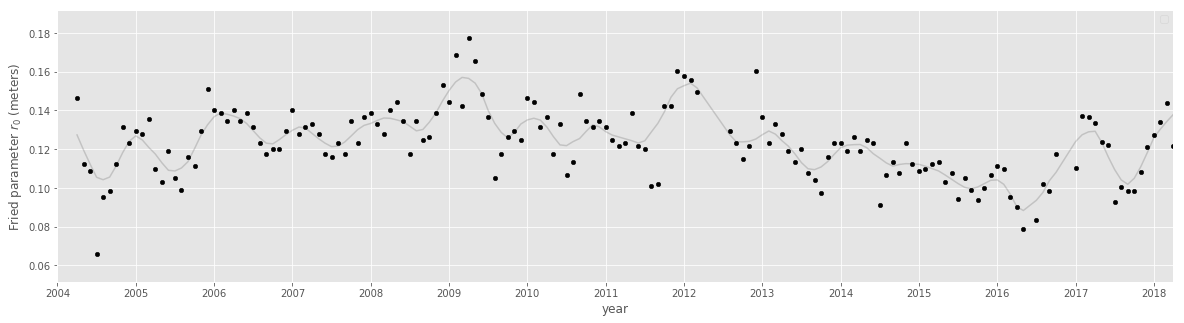

In [11]:
mpl.rcParams['figure.figsize'] = (20, 5)
fig, axes = plt.subplots()

df = dimm.groupby('data_month').agg({'r0': 'median'}).reset_index()
df.plot.scatter('data_month', 'r0', color='black', ax=axes)

df['r0_lowess'] = lowess(df.r0, df.data_month, frac=0.05).T[1]
df.plot('data_month', 'r0_lowess', color='black', alpha=0.15, label='_no_label_', ax=axes)

month_ticks = np.arange(0, 180, 12)
axes.set_xticks(month_ticks)
axes.set_xticklabels(np.min(dimm.year) + (month_ticks/12).astype(int))
axes.set_xlabel('year')
axes.set_ylabel('Fried parameter $r_0$ (meters)')

## Check the distributions for normality

The time series modeling I indend to do works best with data that are normally distributed. Check the distribution of data we actually have.

/data/des60.b/data/neilsen/anaconda/envs/ehn35/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,0,'$\\log(r_0)$')

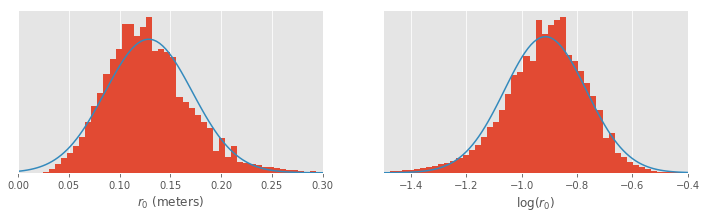

In [12]:
mpl.rcParams['figure.figsize'] = (12, 3)
fig, axes = plt.subplots(1,2)

dimm.r0.hist(bins=50, range=(0,0.3), normed=True, ax=axes[0])
r0_norm_fit = scipy.stats.norm.fit(dimm.r0)
x = np.linspace(0, 0.3, 100)
r0_fit = pd.DataFrame({'x': x,
                       'r0': scipy.stats.norm.pdf(x, loc=r0_norm_fit[0], scale=r0_norm_fit[1])})
r0_fit.plot('x', 'r0', ax=axes[0], legend=False)
#scipy.stats.probplot(dimm.r0, dist=scipy.stats.norm, plot=axes[1,0])


dimm.log_r0.hist(bins=50, range=(-1.5, -0.4), normed=True, ax=axes[1])

lr0_norm_fit = scipy.stats.norm.fit(dimm.log_r0)
x = np.linspace(-1.5, -0.4, 100)
lr0_fit = pd.DataFrame({'x': x,
                       'lr0': scipy.stats.norm.pdf(x, loc=lr0_norm_fit[0], scale=lr0_norm_fit[1])})
lr0_fit.plot('x', 'lr0', ax=axes[1], legend=False)

axes[0].set_yticks([])
axes[0].set_xlabel('$r_0$ (meters)')
#axes[0].set_xlim((0, 0.3))
axes[1].set_yticks([])
axes[1].set_xlabel('$\log(r_0)$')

#scipy.stats.probplot(dimm.log_r0, dist=scipy.stats.norm, plot=axes[1,1])

((array([-4.8565255 , -4.67779401, -4.58119483, ...,  4.58119483,
          4.67779401,  4.8565255 ]),
  array([ -1.69059771e+00,  -1.69042245e+00,  -1.68778502e+00, ...,
          -3.67714720e-02,  -3.67714720e-02,   2.99839422e-04])),
 (0.14702806716053932, -0.91483300166423875, 0.99338166858656241))

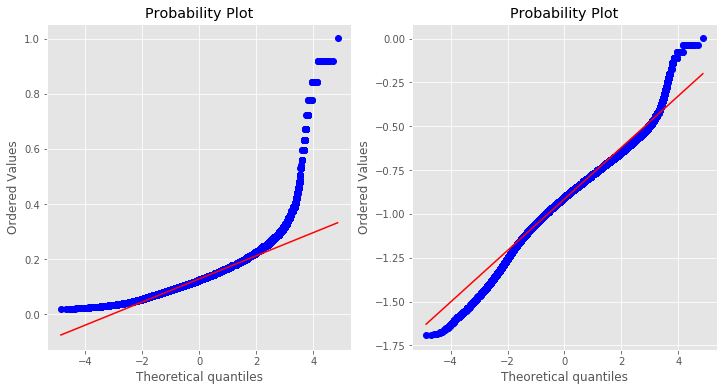

In [13]:
mpl.rcParams['figure.figsize'] = (12, 6)
fig, axes = plt.subplots(1,2)

scipy.stats.probplot(dimm.r0, dist=scipy.stats.norm, plot=axes[0])
scipy.stats.probplot(dimm.log_r0, dist=scipy.stats.norm, plot=axes[1])

In [14]:
print("Skewness:", scipy.stats.skew(dimm.log_r0))
print("Excess kurtosis:", scipy.stats.kurtosis(dimm.log_r0, fisher=True))

Skewness: -0.4456482467842725
Excess kurtosis: 0.8651605042314392


In [15]:
df = dimm
print(scipy.stats.normaltest(df.r0).pvalue, scipy.stats.normaltest(df.log_r0).pvalue)
print(scipy.stats.skewtest(df.r0).pvalue, scipy.stats.skewtest(df.log_r0).pvalue)
print(scipy.stats.kurtosistest(df.r0).pvalue, scipy.stats.kurtosistest(df.log_r0).pvalue)

0.0 0.0
0.0 0.0
0.0 0.0


In [16]:
df = dimm.sample(30000)
print(scipy.stats.normaltest(df.r0).pvalue, scipy.stats.normaltest(df.log_r0).pvalue)
print(scipy.stats.skewtest(df.r0).pvalue, scipy.stats.skewtest(df.log_r0).pvalue)
print(scipy.stats.kurtosistest(df.r0).pvalue, scipy.stats.kurtosistest(df.log_r0).pvalue)

0.0 0.0
0.0 2.5411377532e-212
0.0 6.85413888068e-119


Okay, neither are really Gaussian, but $\log(r_{0})$ is closer to normal than $r_{0}$. One notable feature is the low-value tail of $log(r_0)$. This suggests that there is a poor-seeing tail of the distribution that my model will not be able to model well.

## Plot single night time series

In [17]:
def plot_night_seeing(df, night, fig, axes):
    night_df = df[df.night == night]
    
    night_df.plot(y='log_r0', drawstyle='steps-mid',ax=axes)

    # Add an axes with the DIMM measured seeing on the right
    right_axes = axes.twinx()
    night_df.plot(y='log_r0', drawstyle='steps-mid', ax=right_axes)

    seeing_ticks = np.concatenate((np.arange(0.4, 2.0, 0.2), np.arange(2.0, 4.0, 0.4)), axis=0)
    logr0_ticks = np.log10(0.98*5e-7/np.radians(seeing_ticks/(60*60)))
    right_axes.set_yticks(logr0_ticks)
    right_axes.set_yticklabels(seeing_ticks)
    right_axes.set_ylabel('seeing (")')

    right_axes.set_ylim(axes.get_ylim())
    right_axes.grid(False)
    axes.set_ylabel("$\log(r_{0})$, $r_{0}$ in meters")
    
    axes.xaxis.set_major_formatter(mpl.dates.DateFormatter('%H:%m:%SZ'))
    
    axes.legend().set_visible(False)
    right_axes.legend().set_visible(False)
    
    axes.set_title('Night MJD %d' % night)
    return fig, axes

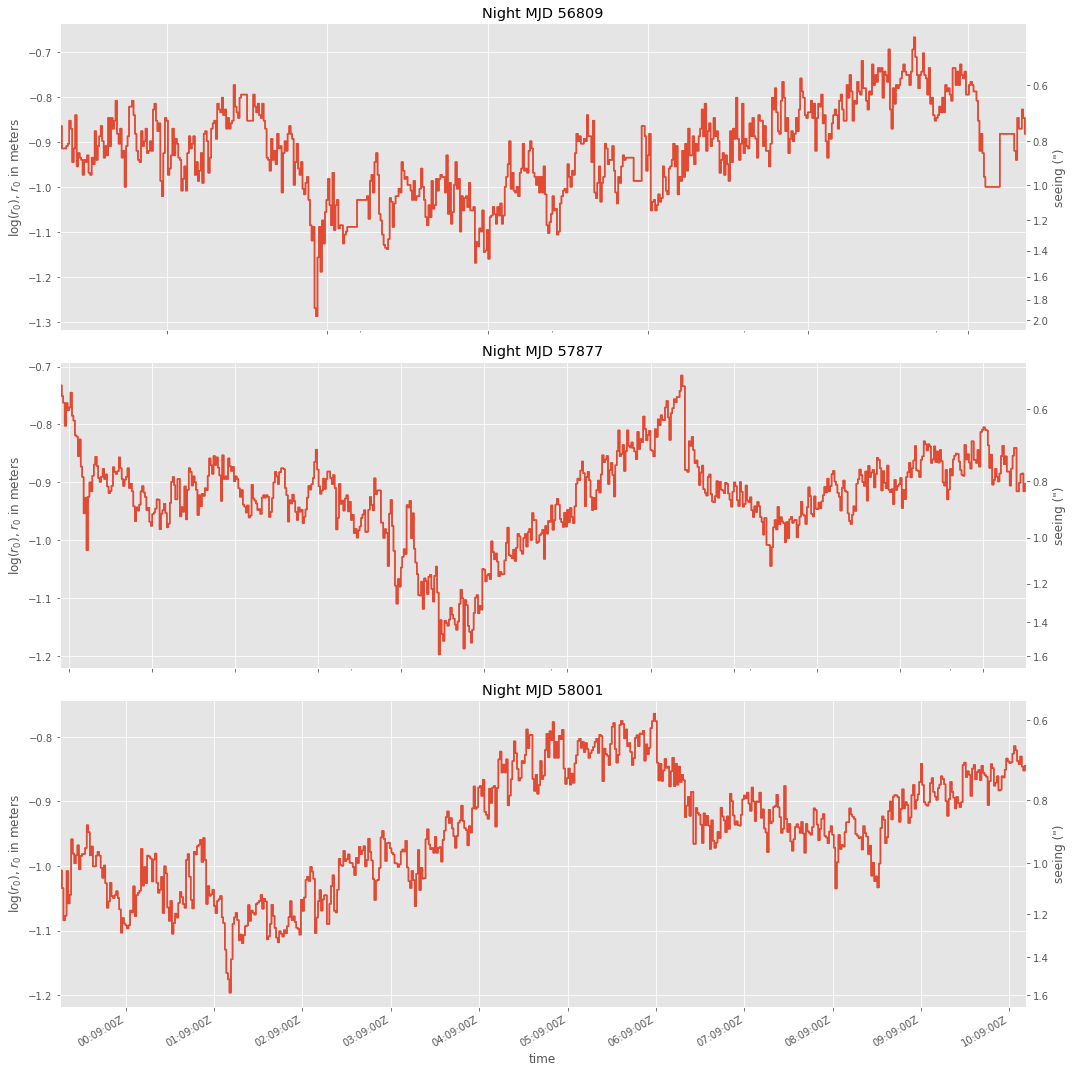

In [23]:
# Explicitly setting a seed make reproducability easier without having to rerun the whole notebook
np.random.seed(4861)

mpl.rcParams['figure.figsize'] = (15, 15)
fig, axes = plt.subplots(3,1)

# Pick some random nights during which the DIMM ran most of the night
sample_nights = dimm.groupby('night').agg({'seeing': 'count'}).query('seeing>600').sample(len(axes.flatten())).index.values
for ax, sample_night in zip(axes.flatten(), np.sort(sample_nights)):
    fig = plot_night_seeing(dimm, sample_night, fig, ax)
    
plt.tight_layout()

## Plot a year time series

In [19]:
def plot_year_seeing(df, year):
    irreg_year_df = df[df.year == year].groupby('night').agg({'log_r0': 'mean'})
        
    # Get a data frame with nights without data set to null
    # by creating a DataFrame with all nighths, then
    # assigning the log_r0 column into it, using pandas
    # index matching to match the rows appropriately
    first_mjd = (pd.to_datetime('%d-01-01' % year, format="%Y-%m-%d") 
                 - pd.to_datetime(2400000.5, unit='D', origin='julian')).days
    last_mjd = first_mjd + 367
    mjds = np.arange(irreg_year_df.index.values.min(), irreg_year_df.index.values.max())
    year_df = pd.DataFrame({'night': mjds,
                            'date': pd.to_datetime(mjds+2400000.5, unit='D', origin='julian')},
                           index=mjds)
    year_df['log_r0'] = irreg_year_df.log_r0
    
    mpl.rcParams['figure.figsize'] = (16, 10)
    fig, axes = plt.subplots()

    year_df.plot(y='log_r0', drawstyle='steps-mid', color='black', alpha=0.05, ax=axes)

    # Set x ticks
    axes.set_xticks(year_df[year_df.date.dt.day == 1].night)
    axes.set_xticklabels(year_df[year_df.date.dt.day == 1].date.dt.strftime('%Y-%m-%d'), rotation=45)
    
    # Add an axes with the DIMM measured seeing on the right
    right_axes = axes.twinx()
    year_df.reset_index().plot.scatter('night', 'log_r0', color='black', ax=right_axes)

    seeing_ticks = np.concatenate((np.arange(0.4, 2.0, 0.1), np.arange(2.0, 4.0, 0.2)), axis=0)
    logr0_ticks = np.log10(0.98*5e-7/np.radians(seeing_ticks/(60*60)))
    right_axes.set_yticks(logr0_ticks)
    right_axes.set_yticklabels(seeing_ticks)
    right_axes.set_ylabel("DIMM reported seeing (arcseconds)")
    
    right_axes.set_ylim(axes.get_ylim())
    right_axes.grid(False)
    axes.set_ylabel("$\log(r_{0})$, $r_{0}$ in meters")
    
    axes.legend().set_visible(False)
    right_axes.legend().set_visible(False)
    # axes.set_title("DIMM nightly means for %d" % year)
    axes.set_xlabel('Night')
    return fig

No handles with labels found to put in legend.


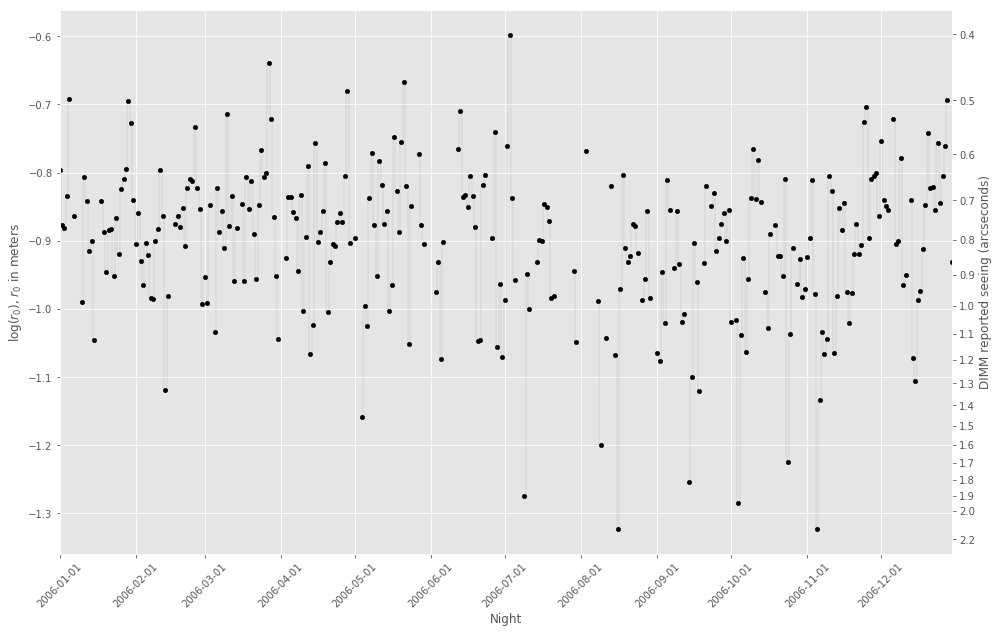

In [20]:
# Find the year with the least missing nights and plot it
year = dimm.groupby(['night', 'year']).agg({'seeing': 'mean'}).reset_index().groupby('year').agg({'night': 'count'}).sort_values('night', ascending=False).index.values[0]
fig = plot_year_seeing(dimm, year)

## Plot nightly means for all nights

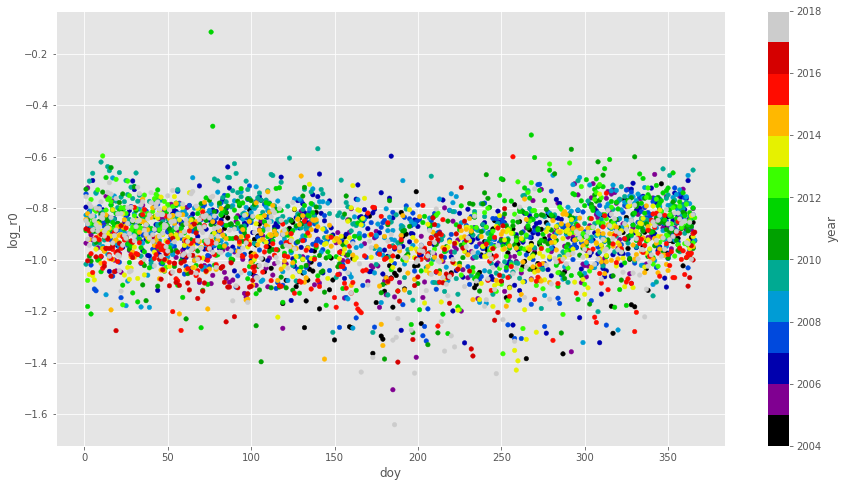

In [58]:
night_means = dimm.groupby('night').agg({'log_r0': 'mean', 'year': 'median'})
night_means['doy'] = pd.to_datetime(2400000.5+night_means.index.values, unit='D', origin='julian').dayofyear

mpl.rcParams['figure.figsize'] = (15, 8)
fig, axes = plt.subplots()

night_means.plot.scatter('doy', 'log_r0', c='year', colormap=mpl.cm.get_cmap('nipy_spectral', 14), ax=axes)


# von Karman model correction

In [78]:
def calc_FWHM_vK(fwhm_dimm, outer_scale=30, wavelength=5.0e-7):
    r0 = 0.98*wavelength/(np.radians(fwhm_dimm/(60*60)))
    fwhm = fwhm_dimm * np.sqrt(1.0 - 2.813*np.power(r0/outer_scale, 0.356) )
    return fwhm

print((0.83-calc_FWHM_vK(0.83, 30))/0.83)
print((0.83-calc_FWHM_vK(0.83, 28.4-13.3))/0.83)
print((0.83-calc_FWHM_vK(0.83, 28.4+25))/0.83)

0.222868301389
0.296947152573
0.17693612435
